In [23]:
import torch
import torch.nn.functional as F
import os
import numpy as np
import matplotlib.pyplot as plt
import argparse
from src.utils import *
from src.mi_estimators import *
from torch.utils.tensorboard import SummaryWriter

In [24]:
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

cuda = True if torch.cuda.is_available() else False
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor
torch.set_default_tensor_type(FloatTensor)

name = './results/PCM' # filename
chkpt_name = name+'.pt'                         # checkpoint
writer = SummaryWriter('./results/log/PCM')

In [25]:
parser = argparse.ArgumentParser()
parser.add_argument("--rho", type=float, default=0.9, help="coefficient of Gaussian")
parser.add_argument("--d", type=int, default=20, help="dimension of X & Y")
parser.add_argument("--sample_size", type=int, default=400, help="sample size")
parser.add_argument("--gamma", type=float, default=1e-20, help="clipping parameter")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--batch_size", type=int, default=40, help="size of the batches")
parser.add_argument("--lr", type=float, default=1e-3, help="adam: learning rate")
parser.add_argument("--hidden_dim", type=int, default=100, help="Hidden dimension")
parser.add_argument("--ma_rate", type=float, default=0.1, help="move average rate")
parser.add_argument("--ma_ef", type=float, default=1, help="move average ef")
parser.add_argument("--alpha", type=float, default=0.1, help="smooth parameter")
parser.add_argument("--reg", type=int, default=0, help="if apply regularization")
parser.add_argument("--n_epoch", type=int, default=1000, help="number of epochs of training")
parser.add_argument("--n_iters_1epoch", type=int, default=10, help="number of epochs of training")

opt, unknown = parser.parse_known_args()
opt.n_iters = opt.n_epoch * opt.n_iters_1epoch
ma_rate = 0.01  # moving average rate

In [26]:
continue_train = True  # set to True to continue to train
load_available = False # set to False to prevent loading previous results
overwrite = True  # set to True to overwrite previously stored results

In [27]:
data = GaussianData(opt.sample_size, d=opt.d, rho=opt.rho)
X, Y, XY, Ground_truth = data.X, data.Y, torch.cat((data.X, data.Y), dim=1), data.mutual_information()

In [28]:
x_tile = X.unsqueeze(0).repeat((X.shape[0], 1, 1))
y_tile = Y.unsqueeze(1).repeat((1, Y.shape[0], 1))
marg_XY = torch.cat([x_tile, y_tile], dim = -1)

In [29]:
discriminator = Prob_Net(input_size=opt.d*2, hidden_size=100)
# move NN model GPU if GPU is available
if cuda:
    discriminator.cuda()

# Adam opetimizer
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

In [30]:
def mi_estimate(model, data_XY, marg_XY, gamma, alpha):
    # clip the output of neural networks
    pre_XY = model(data_XY).clamp(min=gamma, max=1 - gamma)
    pre_margXY = model(marg_XY).clamp(min=gamma, max=1 - gamma)
    MI_est = (pre_XY*torch.log(alpha * pre_XY / ((1 - pre_XY).clamp(min=gamma, max=1 - gamma)))).mean() + \
        (pre_margXY*torch.log(alpha * pre_margXY / ((1 - pre_margXY).clamp(min=gamma, max=1 - gamma)))).mean() 

    return MI_est

In [31]:
load_available = False # set to False to prevent loading previous results
if load_available and os.path.exists(chkpt_name):
    checkpoint = torch.load(
        chkpt_name, map_location='cuda' if torch.cuda.is_available() else 'cpu')
    mi_list = checkpoint['mi_list']
    model_state = checkpoint['model_state']
    discriminator.load_state_dict(model_state)
    print('Previous results loaded.')
else:
    mi_list = [] # storing the mi estimation of each iteration

In [32]:
continue_train = True  # set to True to continue to train
if continue_train:
    for i in range(opt.n_iters):
        data_joint = resample(XY, batch_size=opt.batch_size)
        X_ref = resample(X, batch_size=opt.batch_size)
        Y_ref = resample(Y, batch_size=opt.batch_size)
        data_margin = torch.cat((X_ref, Y_ref), dim=1)
        valid = Variable(torch.Tensor(opt.batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(torch.Tensor(opt.batch_size, 1).fill_(0.0), requires_grad=False)
        train_data = torch.cat((data_joint, data_margin), dim=0)
        labels = torch.cat((valid, fake), dim=0)
        pred_label = discriminator(train_data)

        alpha = data_margin.shape[0]/data_joint.shape[0]

        optimizer_D.zero_grad()
        # PCM loss
        loss = torch.nn.BCELoss()(pred_label, labels)

        loss.backward()
        optimizer_D.step()
        with torch.no_grad():
            mi_est = mi_estimate(discriminator, XY, marg_XY, opt.gamma, alpha)
            if torch.isinf(mi_est):
                mi_est = torch.from_numpy(np.array(mi_list[-1]))
            mi_list.append(mi_est.item())
        writer.add_scalar('mi_list', mi_est.item(), i)
        writer.add_scalar('loss', loss, i)
        if i%500==0:
            print("Iternation: %d, loss: %f, mi_est: %f"%(i, loss.item(), mi_est))
writer.add_graph(discriminator, (XY,))

Iternation: 0, loss: 0.693156, mi_est: 0.001926
Iternation: 500, loss: 0.114992, mi_est: 2.907099
Iternation: 1000, loss: 0.095871, mi_est: 5.434917
Iternation: 1500, loss: 0.021243, mi_est: 6.926548
Iternation: 2000, loss: 0.367620, mi_est: 6.546504
Iternation: 2500, loss: 0.032872, mi_est: 8.049509
Iternation: 3000, loss: 0.006331, mi_est: 7.337223
Iternation: 3500, loss: 0.001389, mi_est: 7.906675
Iternation: 4000, loss: 0.019553, mi_est: 7.855683
Iternation: 4500, loss: 0.004293, mi_est: 7.418640
Iternation: 5000, loss: 0.126325, mi_est: 7.001693
Iternation: 5500, loss: 0.131538, mi_est: 7.262357
Iternation: 6000, loss: 0.001342, mi_est: 7.796874
Iternation: 6500, loss: 0.011587, mi_est: 6.495150
Iternation: 7000, loss: 0.017531, mi_est: 7.140432
Iternation: 7500, loss: 0.000419, mi_est: 7.789581
Iternation: 8000, loss: 0.190482, mi_est: 7.027204
Iternation: 8500, loss: 0.095681, mi_est: 6.918865
Iternation: 9000, loss: 0.001913, mi_est: 7.503692
Iternation: 9500, loss: 0.003806, m

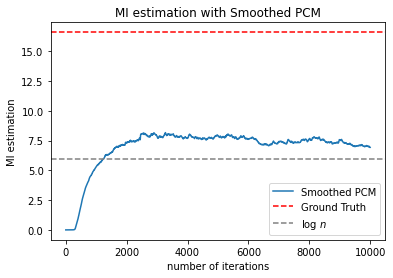

In [33]:
mi_copy = mi_list.copy()
for k in range(1,len(mi_list)):
    mi_copy[k] = (1-ma_rate) * mi_copy[k-1] + ma_rate * mi_copy[k]

plt.plot(mi_copy, label='Smoothed PCM')

plt.axhline(Ground_truth,label='Ground Truth',linestyle='--',color='red')
plt.axhline(np.log(opt.sample_size),label='log $n$',linestyle='--',color='grey')
plt.xlabel('number of iterations')
plt.ylabel('MI estimation')
plt.title('MI estimation with Smoothed PCM')
plt.legend()
plt.savefig(f'results/Smoothed_PCM_dim{opt.d}_ma{ma_rate}.pdf')

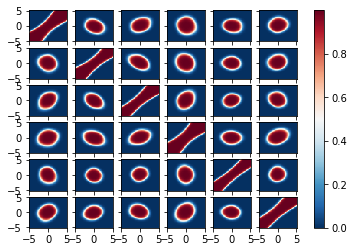

In [34]:
# probabilitic heatmap
heatmap = plot_fig(discriminator, X, Y, d=6)
# plt.savefig(f'./results/heatmap_smoothed_InfoNCE_dim{opt.d}.pdf')